# 충남대학교 컴퓨터비전
# SIFT(Scale-Invarient Feature Transform)

## 목차
### 1. SIFT Overview
### 2. Orientation Histogram
### 2. SIFT(Scale-Invarient Feature Transform)를 이용한 Matching


In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# 이미지 불러오기 - 경로 /content에 이미지 파일 업로드
#from google.colab import files
#file_uploaded = files.upload()

## 1. SIFT Overview

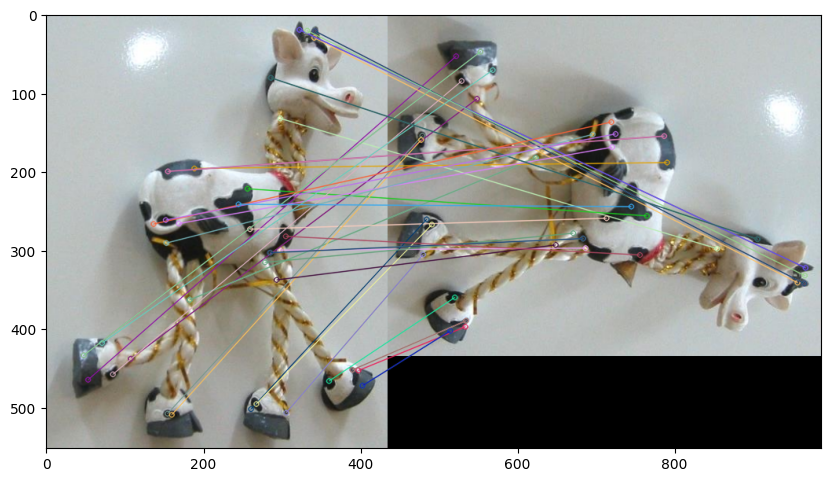

In [2]:
src = cv2.imread('./zebra.png') # 원본 이미지
src_rotation = cv2.rotate(src, cv2.ROTATE_90_CLOCKWISE) # 시계방향으로 90도 회전된 이미지

# Opencv 내장 SIFT 객체 선언
# 50은 추출할 keypoint 개수

sift = cv2.SIFT_create(50)

# SIFT 알고리즘은 이미지를 입력받아서 keypoint와 descriptor를 반환
kp1, des1 = sift.detectAndCompute(src,None)
kp2, des2 = sift.detectAndCompute(src_rotation,None)

## Matching 부분 ##
bf = cv2.BFMatcher_create(cv2.NORM_HAMMING, crossCheck=True)
des1 = des1.astype(np.uint8)
des2 = des2.astype(np.uint8)

matches = bf.match(des1, des2)
matches = sorted(matches, key=lambda x: x.distance)

result = cv2.drawMatches(src, kp1, src_rotation, kp2, matches, outImg=None, flags=2)

plt.figure(figsize=(10,10))
plt.imshow(result[:, :, ::-1])
plt.show()

## 2. Orientation Histogram

image shape: (512, 512)


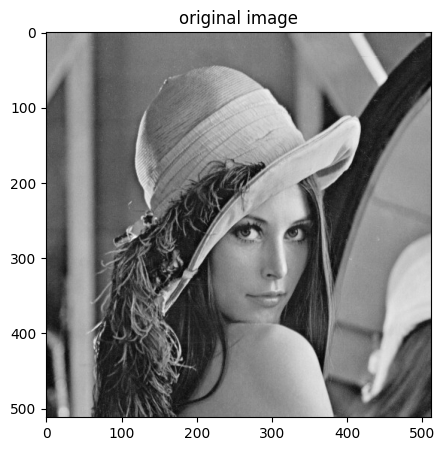

patch shape:(32, 32)


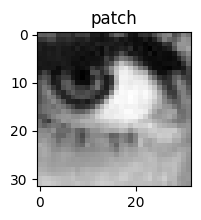

patch angle shape: (32, 32)
patch magnitude shape: (32, 32)
주각도: 130.0


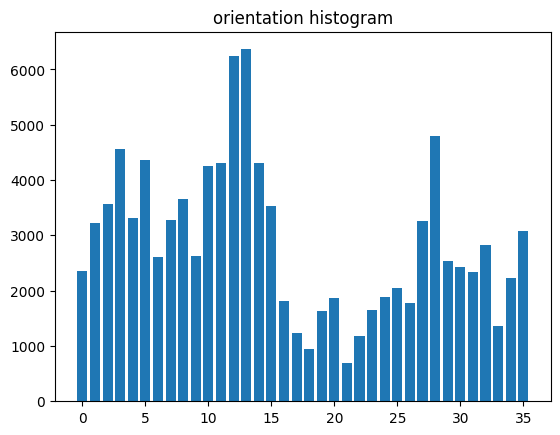

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math

def my_padding(src, filter):
    (h, w) = src.shape
    if isinstance(filter, tuple):
        (h_pad, w_pad) = filter
    else:
        (h_pad, w_pad) = filter.shape
    h_pad = h_pad // 2
    w_pad = w_pad // 2
    padding_img = np.zeros((h + h_pad * 2, w + w_pad * 2))
    padding_img[h_pad:h + h_pad, w_pad:w + w_pad] = src

    # repetition padding
    # up
    padding_img[:h_pad, w_pad:w_pad + w] = src[0, :]
    # down
    padding_img[h_pad + h:, w_pad:w_pad + w] = src[h - 1, :]
    # left
    padding_img[:, :w_pad] = padding_img[:, w_pad:w_pad + 1]
    # right
    padding_img[:, w_pad + w:] = padding_img[:, w_pad + w - 1:w_pad + w]

    return padding_img


def my_filtering(src, filter):
    (h, w) = src.shape
    (f_h, f_w) = filter.shape

    # filter 확인
    # print('<filter>')
    # print(filter)

    # 직접 구현한 my_padding 함수를 이용
    pad_img = my_padding(src, filter)

    dst = np.zeros((h, w))
    for row in range(h):
        for col in range(w):
            dst[row, col] = np.sum(pad_img[row:row + f_h, col:col + f_w] * filter)

    return dst


def get_my_sobel():
    sobel_x = np.dot(np.array([[1], [2], [1]]), np.array([[-1, 0, 1]]))
    sobel_y = np.dot(np.array([[-1], [0], [1]]), np.array([[1, 2, 1]]))
    return sobel_x, sobel_y


def calc_derivatives(src):
    # calculate Ix, Iy
    sobel_x, sobel_y = get_my_sobel()
    Ix = my_filtering(src, sobel_x)
    Iy = my_filtering(src, sobel_y)
    return Ix, Iy

def show_patch_hist(patch_vector):
    index = np.arange(len(patch_vector))
    plt.bar(index, patch_vector)
    plt.title('orientation histogram')
    plt.show()


def main():
    src = cv2.imread('Lena.png')
    gray = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY)

    print('image shape: {}'.format(gray.shape))

    plt.figure(figsize=(5,5))
    plt.imshow(gray, cmap='gray')
    plt.title('original image')
    plt.show()

    Ix, Iy = calc_derivatives(gray)

    ###############################################################
    # Image gradient(Ix, Iy)에서 angle 및 magnitude 구하
    # np.arctan2는 -180 ~ 180도 의 값을 가짐
    # -180~180의 각을 모두 x축의 양의 방향으로부터의 0 ~ 360범위로 변환
    # 즉 음의 각도 [-180 ~ 0) (0은 포함 안됨)을 180 ~ 359.9999... 의 각도로 변환 한다는 의미
    # 양수는 기존의 0~180 그대로 유지
    # 예를들어 -90의 경우 -> 270
    angle = np.rad2deg(np.arctan2(Iy, Ix))  ## -180 ~ 180으로 표현
    angle = (angle + 360) % 360  ## 0 ~ 360으로 표현
    magnitude = np.sqrt(Ix ** 2 + Iy ** 2)
    ###############################################################

    ###############################################################
    # 32 x 32 patch
    p_size = 32 # 패치의 size
    p_h = 256
    p_w = 256

    patch = gray[p_h:p_h+p_size, p_w:p_w+p_size]
    ###############################################################

    print('patch shape:{}'.format(patch.shape))
    plt.figure(figsize=(2,2))
    plt.imshow(patch, cmap='gray')
    plt.title('patch')
    plt.show()

    patch_ang = angle[p_h:p_h+p_size, p_w:p_w+p_size]
    patch_mag = magnitude[p_h:p_h+p_size, p_w:p_w+p_size]

    ###############################################################
    # Orientation Assignment 과정
    # angle_range는 360을 몇 등분을 할지를 결정하는 값
    # 예를들어 10이면 360를 36등분 (10도씩 구간을 구분)
    # 0   ~ 10 : index 0
    # 11  ~ 20 : index 1
    # 21  ~ 31 : index 2
    # .......
    # 351 ~ 359 : index 35
    # 총 36개로 분할
    ###############################################################
    angle_range = 10.

    h, w = patch.shape[:2]
    vector_size = int(360 // angle_range) # 36 등분
    vector = np.zeros(vector_size, )
    for row in range(h):
        for col in range(w):
            vector[int(patch_ang[row, col] // angle_range)] += patch_mag[row, col]

    ###############################################################

    print("patch angle shape: {}".format(patch_ang.shape))
    print("patch magnitude shape: {}".format(patch_mag.shape))
    print("주각도: {}".format(np.argmax(vector)*angle_range))

    show_patch_hist(vector)


main()

image shape: (512, 512)


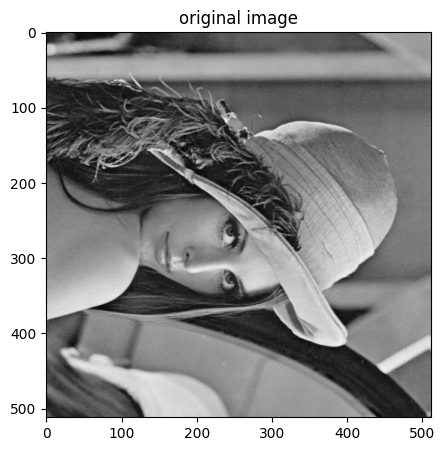

patch shape:(32, 32)


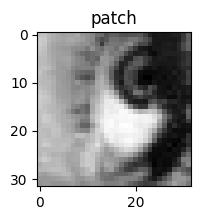

patch angle shape: (32, 32)
patch magnitude shape: (32, 32)
주각도: 220.0


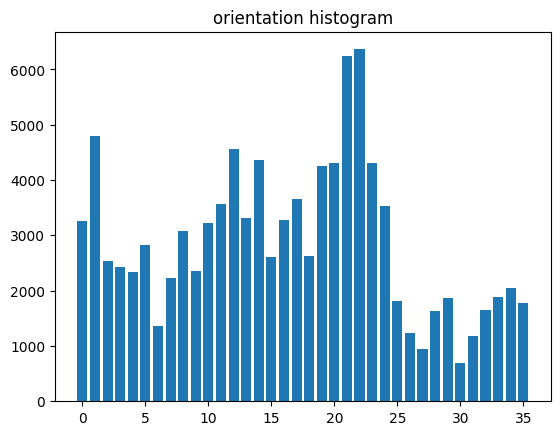

In [4]:
def main2():
    src = cv2.imread('Lena.png')
    src = cv2.rotate(src, cv2.ROTATE_90_CLOCKWISE)
    gray = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY)

    cv2.imwrite('gray.png', gray)
    h, w = gray.shape
    print('image shape: {}'.format(gray.shape))

    plt.figure(figsize=(5,5))
    plt.imshow(gray, cmap='gray')
    plt.title('original image')
    plt.show()

    Ix, Iy = calc_derivatives(gray)

    ###############################################################
    # Image gradient(Ix, Iy)에서 angle 및 magnitude 구하
    # np.arctan2는 -180 ~ 180도 의 값을 가짐
    # -180~180의 각을 모두 x축의 양의 방향으로부터의 0 ~ 360범위로 변환
    # 즉 음의 각도 [-180 ~ 0) (0은 포함 안됨)을 180 ~ 359.9999... 의 각도로 변환 한다는 의미
    # 양수는 기존의 0~180 그대로 유지
    # 예를들어 -90의 경우 -> 270
    angle = np.rad2deg(np.arctan2(Iy, Ix))  ## -180 ~ 180으로 표현
    angle = (angle + 360) % 360  ## 0 ~ 360으로 표현
    magnitude = np.sqrt(Ix ** 2 + Iy ** 2)
    ###############################################################

    ###############################################################
    # 32 x 32 patch
    p_size = 32 # 패치의 size

    row = 256
    col = 256

    degree = 90

    theta = np.deg2rad(degree)
    cos_angle = np.cos(theta)
    sin_angle = np.sin(theta)

    row_rot = np.round((cos_angle * col) + (sin_angle * row))
    col_rot = np.round((cos_angle * col) - (sin_angle * row))

    col_rot += w
    row_rot = int(row_rot)
    col_rot = int(col_rot)

    patch = gray[row_rot:row_rot + p_size, col_rot - p_size:col_rot]

    cv2.imwrite('patch.png', patch)
    ###############################################################

    print('patch shape:{}'.format(patch.shape))
    plt.figure(figsize=(2,2))
    plt.imshow(patch, cmap='gray')
    plt.title('patch')
    plt.show()

    patch_ang = angle[row_rot:row_rot + p_size, col_rot - p_size:col_rot]
    patch_mag = magnitude[row_rot:row_rot + p_size, col_rot - p_size:col_rot]

    ###############################################################
    # Orientation Assignment 과정
    # angle_range는 360을 몇 등분을 할지를 결정하는 값
    # 예를들어 10이면 360를 36등분 (10도씩 구간을 구분)
    # 0   ~ 10 : index 0
    # 11  ~ 20 : index 1
    # 21  ~ 31 : index 2
    # .......
    # 351 ~ 359 : index 35
    # 총 36개로 분할
    ###############################################################
    angle_range = 10.

    h, w = patch.shape[:2]
    vector_size = int(360 // angle_range) # 36 등분
    vector = np.zeros(vector_size, )
    for row in range(h):
        for col in range(w):
            vector[int(patch_ang[row, col] // angle_range)] += patch_mag[row, col]

    ###############################################################

    print("patch angle shape: {}".format(patch_ang.shape))
    print("patch magnitude shape: {}".format(patch_mag.shape))
    print("주각도: {}".format(np.argmax(vector)*angle_range))

    show_patch_hist(vector)


main2()

## 3. 과제 - SIFT를 이용한 Matching

get keypoint
keypoints counts :  94
get Ix and Iy...
calculate angle and magnitude
calculate orientation assignment
총 key point 개수 : 94
calculate descriptor
get keypoint
keypoints counts :  94
get Ix and Iy...
calculate angle and magnitude
calculate orientation assignment
총 key point 개수 : 94
calculate descriptor


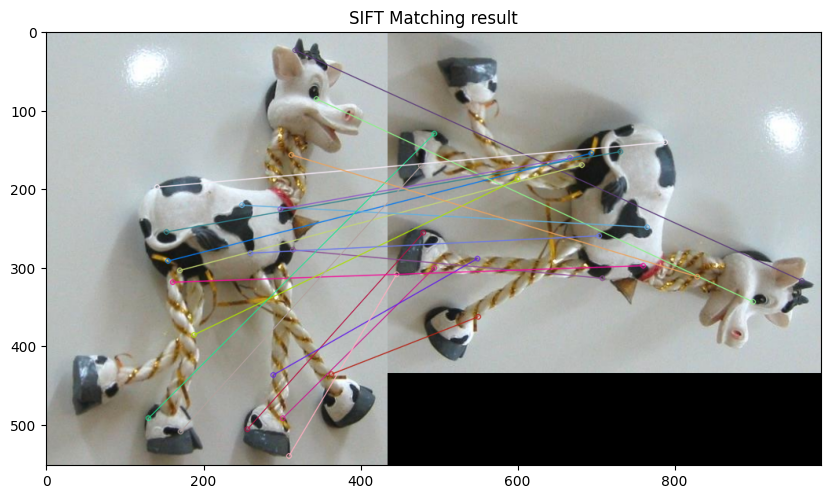

In [8]:
import cv2
import numpy as np

from cv2 import KeyPoint


def my_padding(src, filter):
    (h, w) = src.shape
    if isinstance(filter, tuple):
        (h_pad, w_pad) = filter
    else:
        (h_pad, w_pad) = filter.shape
    h_pad = h_pad // 2
    w_pad = w_pad // 2
    padding_img = np.zeros((h + h_pad * 2, w + w_pad * 2))
    padding_img[h_pad:h + h_pad, w_pad:w + w_pad] = src

    # repetition padding
    # up
    padding_img[:h_pad, w_pad:w_pad + w] = src[0, :]
    # down
    padding_img[h_pad + h:, w_pad:w_pad + w] = src[h - 1, :]
    # left
    padding_img[:, :w_pad] = padding_img[:, w_pad:w_pad + 1]
    # right
    padding_img[:, w_pad + w:] = padding_img[:, w_pad + w - 1:w_pad + w]

    return padding_img


def my_filtering(src, filter):
    (h, w) = src.shape
    (f_h, f_w) = filter.shape

    # filter 확인
    # print('<filter>')
    # print(filter)

    # 직접 구현한 my_padding 함수를 이용
    pad_img = my_padding(src, filter)

    dst = np.zeros((h, w))
    for row in range(h):
        for col in range(w):
            dst[row, col] = np.sum(pad_img[row:row + f_h, col:col + f_w] * filter)

    return dst


def get_my_sobel():
    sobel_x = np.dot(np.array([[1], [2], [1]]), np.array([[-1, 0, 1]]))
    sobel_y = np.dot(np.array([[-1], [0], [1]]), np.array([[1, 2, 1]]))
    return sobel_x, sobel_y


def calc_derivatives(src):
    # calculate Ix, Iy
    sobel_x, sobel_y = get_my_sobel()
    Ix = my_filtering(src, sobel_x)
    Iy = my_filtering(src, sobel_y)
    return Ix, Iy


def find_local_maxima(src, ksize):
    (h, w) = src.shape
    pad_img = np.zeros((h + ksize, w + ksize))
    pad_img[ksize // 2:h + ksize // 2, ksize // 2:w + ksize // 2] = src
    dst = np.zeros((h, w))

    for row in range(h):
        for col in range(w):
            max_val = np.max(pad_img[row: row + ksize, col:col + ksize])
            if max_val == 0:
                continue
            if src[row, col] == max_val:
                dst[row, col] = src[row, col]

    return dst


def SIFT(src):
    gray = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY).astype(np.float32)

    print("get keypoint")
    dst = cv2.cornerHarris(gray, 3, 3, 0.04)
    dst[dst < 0.01 * dst.max()] = 0
    dst = find_local_maxima(dst, 21)
    dst = dst / dst.max()

    # harris corner에서 keypoint를 추출
    # np.nonzero : Return the indices of the elements that are non-zero.
    y, x = np.nonzero(dst)

    #########################################################################
    # Keypoint에 대한 정보를 Keypoint class의 객체로서 저장(Matching을 할때 사용하기 위함)
    # Arguments 정보
    # pt_x, pt_y : keypoint의 x,y좌표
    # size : keypoint 직경(과제에서는 사용하지 않음 None 설정)
    # key_angle : keypoint의 orientation(histogram을 사용해서 구함)
    # response : 위의 주어진 keypoint 좌표에서의 값이 keypoint(본 과제에서는 harris response를 사용)
    # octave : scale의 변화를 확인하기 위한 값(과제에서는 사용하지 않음, 즉 scale을 고려하지 않음)
    # class id : object id (-1로 설정)
    #########################################################################
    keypoints = []
    for i in range(len(x)):
        # x, y, size, angle, response, octave, class_id
        pt_x = int(x[i])  # point x
        pt_y = int(y[i])  # point y
        size = None
        key_angle = -1.
        response = dst[y[i], x[i]]  # keypoint에서 harris corner의 측정값
        octave = 0  # octave는 scale 변화를 확인하기 위한 값 (현재 과제에서는 사용안함)
        class_id = -1
        keypoints.append(KeyPoint(pt_x, pt_y, size, key_angle, response, octave, class_id))

        #################################################
        # 참고 : 주석 풀어서 사용 할 것 (디버깅을 통해서 하면 더 간편)
        # Keypoint 객체 속성 값 확인
        # Keypoints[0].pt
        # Keypoints[0].size
        # Keypoints[0].angle
        # Keypoints[0].response
        # Keypoints[0].octave 등등
        # print(keypoints[0].pt)
        # print(keypoints[0].angle)
        # print(keypoints[0].response)
        # print(keypoints[0].octave)
        #################################################

    print('keypoints counts :  {}'.format(len(keypoints)))
    print('get Ix and Iy...')
    Ix, Iy = calc_derivatives(gray)

    print('calculate angle and magnitude')

    ##########################################
    # Todo
    # magnitude / angle 계산
    ##########################################
    magnitude = np.sqrt(Ix**2 + Iy**2)
    angle = np.arctan2(Iy, Ix)  # radian 값
    angle = np.rad2deg(angle)  # radian 값을 degree로 변경 > -180 ~ 180도로 표현
    angle = (angle + 360) % 360  # -180 ~ 180을 0 ~ 360의 표현으로 변경

    # keypoint 방향
    print('calculate orientation assignment')

    num = 0  # 추가된 keypoint 개수
    for i in range(len(keypoints)):
        x, y = keypoints[i].pt

        # 36등분 10도 간격
        orient_hist = np.zeros(36, )
        # keypont 점에 대한 16 x 16 window 영역
        for row in range(-8, 8):
            for col in range(-8, 8):
                p_y = int(y + row)
                p_x = int(x + col)
                if p_y < 0 or p_y > src.shape[0] - 1 or p_x < 0 or p_x > src.shape[1] - 1:
                    continue  # 이미지를 벗어나는 부분에 대한 처리

                ##########################################
                # Todo
                # Orientation Assignment for keypoint
                ##########################################
                gaussian_weight = np.exp((-1 / 16) * (row ** 2 + col ** 2))
                orient_hist[int(angle[p_y, p_x] // 10)] += magnitude[p_y, p_x]*gaussian_weight

        ###################################################################
        ## ToDo
        ##
        ## orient_hist에서 가중치가 가장 큰 값을 추출하여 keypoint의 angle으로 설정
        ## orient_hist에서 가장 큰 가중치의 0.8배보다 큰 가중치의 값도 keypoint의 angle로 설정
        ## 즉 같은 keypoint에 대한 angle정보가 2개이상 있을 수 있음
        ## 이러한 정보 또한 KeyPoint 클래스를 사용하여 저장
        ## angle은 0 ~ 360도의 표현으로 저장해야 함
        ## np.max, np.argmax를 활용하면 쉽게 구할 수 있음
        ## keypoints[i].angle = ?
        ###################################################################

        # 가장 큰 가중치값의 angle 저장
        keypoints[i].angle = float(np.argmax(orient_hist)*10)

        # orient_hist에서 가장 큰 가중치의 0.8배보다 큰 가중치의 값도 keypoint의 angle로 설정하여
        # KeyPoint의 클래스의 객체로 저장
        # 예시
        # keypoints.append(KeyPoint(pt_x, pt_y, size, key_angle, response, octave, class_id)



    # 위의 과정이 올바르게 구현 되었는지 확인
    # 160개
    print("총 key point 개수 : {}".format(len(keypoints)))

    print('calculate descriptor')

    # 8 orientation * 4 * 4 = 128 dimensions
    descriptors = np.zeros((len(keypoints), 128))

    for i in range(len(keypoints)):
        x, y = keypoints[i].pt
        theta = np.deg2rad(keypoints[i].angle) # 호도법 -> radian
        # 키포인트 각도 조정을 위한 cos, sin값
        cos_angle = np.cos(theta)
        sin_angle = np.sin(theta)

        #######################################
        # Keypoint을 기준으로 16 x 16 patch를 추출
        # 2중 for문을 돌면서 16 x 16 window내의 모든 점을 순회 ->  [-8, 8)
        for row in range(-8, 8):
            for col in range(-8, 8):

                # 회전을 고려한 point값을 얻어냄
                row_rot = np.round((cos_angle * col) + (sin_angle * row))
                col_rot = np.round((cos_angle * col) - (sin_angle * row))

                p_y = int(y + row_rot)
                p_x = int(x + col_rot)
                if p_y < 0 or p_y > (src.shape[0] - 1) \
                        or p_x < 0 or p_x > (src.shape[1] - 1):
                    continue

                ###################################################################
                ## ToDo
                ## descriptor을 완성
                ## 회전 변환된 윈도우 좌표에 대해서 angle histogram을 구함
                ## descriptor angle : angle[p_y, p_x] - keypoints[i].angle
                ## descriptor angle을 8개의 orientation( 0 ~ 7 connect)으로 표현
                ## 4×4의 window에서 8개의 orientation histogram으로 표현
                ## 최종적으로 128개 (8개의 orientation * 4 * 4)의 descriptor를 가짐
                ## gaussian_weight = np.exp((-1 / 16) * (row_rot ** 2 + col_rot ** 2))
                ###################################################################

                # descriptor angle 값
                descriptor_angle = angle[p_y, p_x] - keypoints[i].angle

                # 조정된 angle 값 : 0 ~ 7 범위의 값 가짐
                # 현재 angle 값을  8개의 orientation로 표현하기
                new_bin = round(descriptor_angle / 45)

                if new_bin > 7:
                    new_bin -= 8

                if new_bin < 0:
                    new_bin += 8
                gaussian_weight = np.exp((-1 / 16) * (row_rot ** 2 + col_rot ** 2))
                k = ((row+8)//4)*4+((col+8)//4)
                # descriptors에 gausian weights 반영한 magnitude 값 저장
                descriptors[i, new_bin + 8*k] += gaussian_weight*magnitude[p_y, p_x]




    return keypoints, descriptors


def main():
    src = cv2.imread("zebra.png")
    src_rotation = cv2.rotate(src, cv2.ROTATE_90_CLOCKWISE)

    # 회전된 이미지 확인하고 싶으면 주석 풀어서 확인해 볼 것
    # cv2.imshow('rotation image', src_rotation)
    # cv2.waitKey()
    # cv2.destroyAllWindows()

    kp1, des1 = SIFT(src)
    kp2, des2 = SIFT(src_rotation)

    ## Matching 부분 수정 금지 ##
    bf = cv2.BFMatcher_create(cv2.NORM_HAMMING, crossCheck=True)
    des1 = des1.astype(np.uint8)
    des2 = des2.astype(np.uint8)
    matches = bf.match(des1, des2)
    matches = sorted(matches, key=lambda x: x.distance)

    result = cv2.drawMatches(src, kp1, src_rotation, kp2, matches[:20], outImg=None, flags=2)


    plt.figure(figsize=(10,10))
    plt.imshow(result[:, :, ::-1])
    plt.title("SIFT Matching result")
    plt.show()

main()
